In [16]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import pickle
from tqdm import tqdm

In [17]:
labels = pd.read_csv('./train_label.csv')

In [18]:
labels.head()

,name,height,left,top,width,label
0,1.png,219,246,77,81,1
1,1.png,219,323,81,96,9
2,2.png,32,77,29,23,2
3,2.png,32,98,25,26,3
4,3.png,15,17,5,8,2


In [19]:
train_path = '../data/train/' #### TO BE CHANGEDDDDD
train_images = os.listdir(train_path)

In [20]:
kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]], np.float32)
def pre_process(path,name, factor=1.3):
    """
    Preprocess image: RGB image --> Gray image --> Blur image (reduce noise) --> High Pass Filter (sharpen)         --> Constrast Limited Adaptive Histogram Equalization --> Exposure
    @INPUT:
        - path: image path
        - name: image name
        - factor: exposure factor
    @OUTPUT:
        - imgAHE: preprocessed image
    """

    img = cv2.imread(os.path.join(path, name))

    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray image

    imgBlur = cv2.GaussianBlur(imgGray, (3,3), 0)   # reduce noise

    imgH = cv2.filter2D(imgBlur, -1, kernel)        # sharpen

    AHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))# Contrast Limited Adaptive Histogram Equalization 
    imgAHE = AHE.apply(imgH)
    imgAHE = np.array(imgAHE)

    img_processed = imgAHE*factor   # exposure

    return img_processed

In [21]:
def get_cropped(path,labels, i):
    #image = cv2.imread(os.path.join(train_path, labels['name'][i]))
    image = pre_process(path, labels['name'][i])
    x1 = labels['top'][i]
    if (x1 < 0): 
        x1 = 0
    x2 = x1 + labels['height'][i]
    #if x2 < 0: x2 = 0
    y1 = labels['left'][i]
    if (y1 < 0): 
        y1 = 0
    y2 = y1 + labels['width'][i]
    #if y2 < 0: y2 = 0
    cropimg = image[x1:x2,y1:y2]
    
    return cropimg

In [22]:
def resize_img(img, option = 0):
    #option 0: 16x32
    #option 1: 8x16
    if option == 0:
        dim = (16,32)
    elif option == 1:
        dim = (8,16)
    #print(img.shape)
    img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img_resized

In [23]:
filename = 'HOG_16x32'
num_desc = 756
tosave = np.zeros((len(train_images), num_desc))
for i in tqdm(range(len(train_images))):
    I = get_cropped(train_path,labels, i)
    I = resize_img(I, option =0)
    desc= hog(I, orientations= 9, pixels_per_cell = (4,4), cells_per_block = (2,2))
    #print(tosave[i,:].shape)
    
    #print('i is', i)
    tosave[i,:] = desc 

100%|██████████| 33402/33402 [00:45<00:00, 739.62it/s]


In [24]:
fileObj = open('./' + filename, 'wb')
pickle.dump(tosave, fileObj)
fileObj.close()

In [25]:
#tosave[0:1,:]

1.png


name      1.png
height      219
left        246
top          77
width        81
label         1
Name: 0, dtype: object

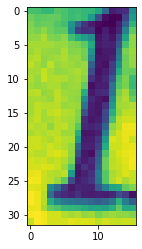

In [27]:
index = 0
#image = cv2.imread(os.path.join(train_path, labels['name'][index]))
todisp = resize_img(get_cropped(train_path,labels, index))
plt.imshow(todisp)
print(labels['name'][index])
labels.loc[index]

In [28]:
todisp.shape

(32, 16)

In [29]:
des , hogim = hog(todisp, pixels_per_cell = (8,8), cells_per_block = (4,2), visualize = True)


In [30]:
des.shape

(72,)

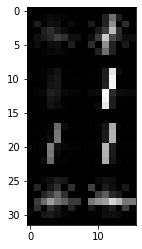

In [31]:
plt.imshow(hogim, cmap = 'gray')